Neural networks are excellent computational tools for highly non-linear problem spaces. However, when the input feature space is polluted by noise, their performance suffers. The most popular deep learning frameworks - TensorFlow and PyTorch - do not provide off the shelf feature selection support. 

How is the performance of a neural network impacted by the presence of a noisy feature space and what alternatives are available? 

In [1]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import xgboost as xgb

We will first create $y$ which we will then try to model using a fully-connected feedforward neural network. Let 
$$ y = \frac{1}{2}x_1^2 + \frac{\sqrt{5}}{2}x_2 + \frac{1}{3}x_3^3 + \epsilon $$

In [2]:
def func(X):
    return X[:,0] ** 2 / 2 + X[:,1] * np.sqrt(5) / 2 + X[:,2] ** 3 / 3 + np.random.normal(scale=1e-5, size=X.shape[0])

In [3]:
X = np.random.normal(size=(50000,3))

In [4]:
y = func(X)

In [5]:
train_ix = random.sample(range(X.shape[0]), int(0.8 * X.shape[0]))
test_ix = np.setdiff1d([i for i in range(X.shape[0])], train_ix)

In [6]:
X_train = X[train_ix]
X_test = X[test_ix]
y_train = y[train_ix]
y_test = y[test_ix]

In [7]:
data = [X_train, y_train, X_test, y_test]

Try to model this relationship using regression:

In [8]:
def run_train(model, X_train, y_train, X_test, y_test):
  model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.RMSprop())
  
  history = model.fit(X_train, 
                      y_train, 
                      batch_size=64, 
                      epochs=25, 
                      validation_data=(X_test, y_test), 
                      verbose=0)
  return history

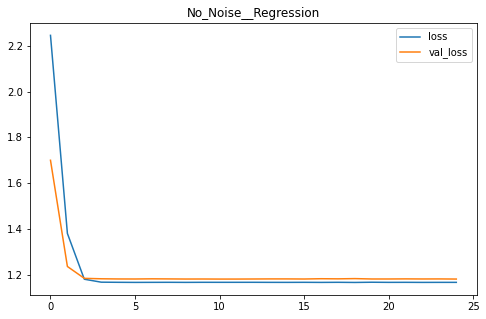

In [9]:
inputs = tf.keras.layers.Input(shape=(3,))
outputs = tf.keras.layers.Dense(1)(inputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='No_Noise__Regression')

history = run_train(model, *data)

pd.DataFrame(history.history).plot(figsize=(8,5), title=model.name);

In [10]:
r1 = model.evaluate(X_test, y_test, verbose=0); round(r1, 2)

1.18

Now we model the relationship using a hidden layer with non-linear activation:

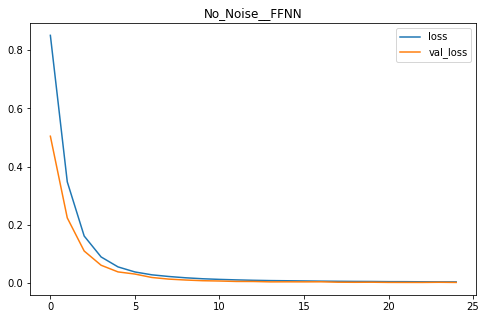

In [11]:
inputs = tf.keras.layers.Input(shape=(3,))
dense = tf.keras.layers.Dense(64, activation="relu")(inputs)
outputs = tf.keras.layers.Dense(1)(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='No_Noise__FFNN')

history = run_train(model, *data)

pd.DataFrame(history.history).plot(figsize=(8,5), title=model.name);

In [12]:
r2 = model.evaluate(X_test, y_test, verbose=0); round(r2, 2)

0.0

Now we introduce additional input features to see if the model can learn as good a representation in $\hat{y}$:

In [13]:
X_noisey = np.hstack((X, np.random.normal(size=(50000,997))))

X_train = X_noisey[train_ix]
X_test = X_noisey[test_ix]

data = [X_train, y_train, X_test, y_test]

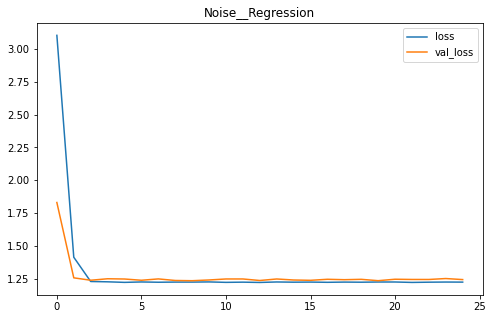

In [14]:
inputs = tf.keras.layers.Input(shape=(1000,))
outputs = tf.keras.layers.Dense(1)(inputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Noise__Regression')

history = run_train(model, *data)

pd.DataFrame(history.history).plot(figsize=(8,5), title=model.name);

In [15]:
r3 = model.evaluate(X_test, y_test, verbose=0); round(r3, 2)

1.24

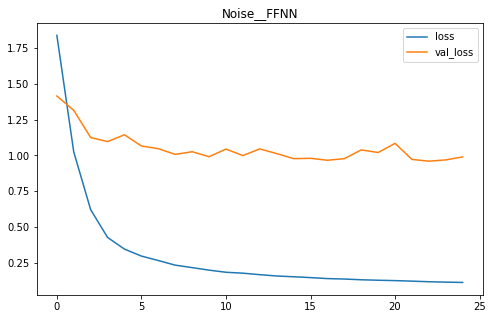

In [16]:
inputs = tf.keras.layers.Input(shape=(1000,))
dense = tf.keras.layers.Dense(1000, activation="relu")(inputs)
outputs = tf.keras.layers.Dense(1)(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Noise__FFNN')

history = run_train(model, *data)

pd.DataFrame(history.history).plot(figsize=(8,5), title=model.name);

In [17]:
r4 = model.evaluate(X_test, y_test, verbose=0); round(r4, 2)

0.99

A neural network having one hidden layer with ReLU activation fails to learn the underlying mapping and overfits to the noise in the training data yielding relatively high test error.

Tree-based methods offer an efficient alternative for this special case of problem; [XGBoost](https://xgboost.readthedocs.io/en/stable/) is an implementation of gradient boosting first described in  [Friedman (1999)](https://www.jstor.org/stable/2699986). 

In [18]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [19]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'reg:squarederror',  
    } 

steps = 25 

In [20]:
model = xgb.train(param, D_train, steps)

In [21]:
preds = model.predict(D_test)

In [22]:
r5 = np.mean((preds - y_test) ** 2); round(r5, 2)

0.05

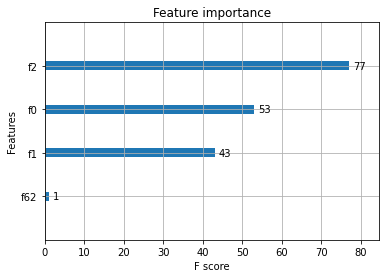

In [23]:
xgb.plot_importance(model);

The boosting model selected only four features out of 1000; the three overwhelmingly higher-ranking features are the 'true' features. 

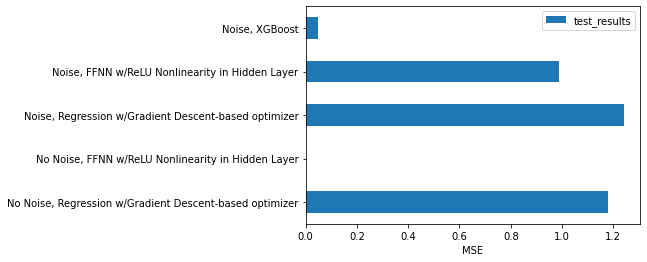

In [24]:
pd.DataFrame({'test_results': [r1, r2, r3, r4, r5]}, 
             index=['No Noise, Regression w/Gradient Descent-based optimizer', 
                    'No Noise, FFNN w/ReLU Nonlinearity in Hidden Layer', 
                    'Noise, Regression w/Gradient Descent-based optimizer', 
                    'Noise, FFNN w/ReLU Nonlinearity in Hidden Layer', 
                    'Noise, XGBoost']).plot.barh().set_xlabel('MSE');

Feature selection in deep neural networks is an active area of research. A variety of approaches have been proposed including using dropout on the input layer, augmenting the loss function, or using an alternative optimization algorithm. 

Until major deep learning frameworks incorporate such an explicit feature selection method, neural network practitioners and researchers facing noisy feature spaces must implement a custom solution or use an alternative machine learning method such as a tree-based method which inherently performs feature selection during training.